In [1]:
!pip install ipython jupyterlab ipympl nodejs-bin --break-system-package --upgrade
!pip install jupyter_contrib_nbextensions --break-system-package
!jupyter labextension install --user
!jupyter contrib nbextension install --user
!jupyter nbextension enable varInspector/main
!jupyter labextension install @jupyter-widgets/jupyterlab-manager --user
!jupyter labextension install jupyter-matplotlib --user
!jupyter nbextension enable --py widgetsnbextension
!pip install loguru pyserial --break-system-packages

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
usage: jupyter-labextension [-h] [--debug] [--show-config]
                            [--show-config-json] [--generate-config] [-y]
                            [--no-build] [--no-minimize] [--clean]
                            [--splice-source]
                            [--log-level InstallLabExtensionApp.log_level]
                            [--config InstallLabExtensionApp.config_file]
                            [--app-dir InstallLabExtensionApp.app_dir]
                            [--dev-build [InstallLabExtensionApp.dev_build]]
                            [--minimize InstallLabExtensionApp.minimize]
                            [--debug-log-path InstallLabExtensionApp.debug_log_path]
                            [--pin-version-as InstallLabExtensionApp.pin]
                            [extra_args ...]
jupyter-labextension: er

In [2]:
!jupyter labextension list

`sys_prefix` level settings are read-only, using `user` level for migration to `lockedExtensions`
JupyterLab v4.3.6
/home/user/.local/share/jupyter/labextensions
        jupyter-matplotlib v0.11.7 enabled OK

/usr/local/share/jupyter/labextensions
        jupyterlab_pygments v0.3.0 enabled OK (python, jupyterlab_pygments)
        @pyviz/jupyterlab_pyviz v3.0.4 enabled OK
        @jupyter-notebook/lab-extension v7.3.2 enabled OK
        @jupyter-widgets/jupyterlab-manager v5.0.13 enabled OK (python, jupyterlab_widgets)



In [3]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
%run "../Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍
scope.gain.mode                          changed from low                       to high                     
scope.gain.gain                          changed from 0                         to 30                       
scope.gain.db                            changed from 5.5                       to 24.8359375               
scope.adc.basic_mode                     changed from low                       to rising_edge              
scope.adc.samples                        changed from 24400                     to 5000                     
scope.adc.trig_count                     changed from 2458275838                to 2471713063               
scope.clock.adc_src                      changed from clkgen_x1                 to clkgen_x4                
scope.clock.adc_freq                     changed from 66243953                  to 29538459                 
scope.clock.adc_rate                     changed from 66243953.0                to 29538459.0        

In [4]:
import chipwhisperer as cw
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

time.sleep(0.05)
scope.default_setup()
 
time.sleep(0.05)
scope.io.nrst = 'low'
time.sleep(0.05)
scope.io.nrst = 'high_z'


In [775]:
scope.gain.db = 1
scope.adc.samples = 24000
scope.adc.presamples = 0
scope.clock.adc_src = 'clkgen_x1'
scope.clock.clkgen_freq = 100000000
scope.adc.offset = 0
scope.adc.decimate = 100
scope.adc.basic_mode = "low"
scope.adc.timeout = 1

In [776]:
scope.clock.reset_adc()
assert (scope.clock.adc_locked), "ADC failed to lock"
repeat = 1
traces = []

In [777]:
scope.clock.reset_adc()
%run "./mytarget.ipynb"
target = MyTarget("/dev_host/ttyACM3", 115200)


time to send message:  0.0020372867584228516
time to recv traces:  0.01819133758544922
time to recv message:  0.002091646194458008
0: Operation length: 3822394 cycles


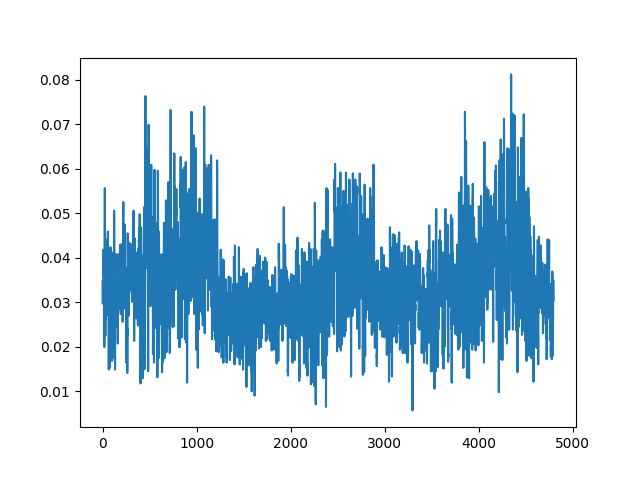

In [782]:
%matplotlib widget

plt.clf()
for i in range(repeat):
    scope.clock.reset_adc()
    init = scope.adc.trig_count
    traces = cw.capture_trace(scope, target, Message(Opcode.LIST, b""))
    #traces = cw.capture_trace(scope, target, Message(Opcode.DECODE, struct.pack("<IQ64s", 0, i, b"A"*64)))
    oplen = scope.adc.trig_count - init
    print('%d: Operation length: %d cycles' % (i, oplen))
    #print(traces)
    raw_data = traces.wave[:]
    R = 5
    max_in_range = [max(raw_data[j:j+R]) for j in range(0, len(raw_data), R)]
    N = 5
    smooth_traces = np.convolve(max_in_range, np.ones(N)/N, mode='valid')
    plt.plot(smooth_traces)
    time.sleep(0.5)

plt.show()


# 